# Task 3: Forecast Future Market Trends

**Objective:** Use trained models to forecast Tesla's future stock prices and analyze the results for actionable insights.

We will generate forecasts for 6-12 months into the future using the ARIMA model, visualize them with confidence intervals, and analyze the market implications.

In [1]:
import sys
import os

# Add the src directory to the path to import modules
sys.path.append(os.path.abspath(os.path.join('..', 'src')))

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from data_loader import fetch_data, clean_data
from models import optimize_arima, train_arima_model

%matplotlib inline

## 1. Load Data and Retrain Best Model

In [2]:
# Load Processed Data
file_path = '../data/processed/cleaned_data.csv'
print(f"Loading data from {file_path}...")
data = pd.read_csv(file_path, index_col=0, parse_dates=True)
tsla_prices = data['TSLA']

# Ensure index is DatetimeIndex
if not isinstance(tsla_prices.index, pd.DatetimeIndex):
    tsla_prices.index = pd.to_datetime(tsla_prices.index)

print(f"Data range: {tsla_prices.index[0].date()} to {tsla_prices.index[-1].date()}")
print(f"Training model on full dataset ({len(tsla_prices)} observations)...")

model_auto = optimize_arima(tsla_prices, seasonal=False)
print(model_auto.summary())

Loading data from ../data/processed/cleaned_data.csv...
Data range: 2015-01-02 to 2026-01-14
Training model on full dataset (2775 observations)...
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 2775
Model:               SARIMAX(1, 1, 0)   Log Likelihood               -9387.370
Date:                Wed, 28 Jan 2026   AIC                          18778.739
Time:                        08:50:37   BIC                          18790.595
Sample:                             0   HQIC                         18783.021
                               - 2775                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0319      0.012     -2.659      0.008      -0.

In [3]:
# Fit the model
final_model = train_arima_model(tsla_prices, order=model_auto.order)

c:\Users\Abenezer\Desktop\KAIM Project\portfolio-optimization\venv9\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Abenezer\Desktop\KAIM Project\portfolio-optimization\venv9\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Abenezer\Desktop\KAIM Project\portfolio-optimization\venv9\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


## 2. Generate Future Forecasts (6-12 Months)

In [4]:
# Forecast for 252 trading days (approx 12 months)
forecast_steps = 252
forecast_res = final_model.get_forecast(steps=forecast_steps)
forecast_mean = forecast_res.predicted_mean
conf_int = forecast_res.conf_int(alpha=0.05) # 95% confidence

# Create a date index for the forecast
last_date = tsla_prices.index[-1]
forecast_index = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=forecast_steps, freq='B')
forecast_mean.index = forecast_index
conf_int.index = forecast_index

print("Forecast Head:")
print(forecast_mean.head())

Forecast Head:
2026-01-15    439.455104
2026-01-16    439.446970
2026-01-19    439.447230
2026-01-20    439.447221
2026-01-21    439.447222
Freq: B, Name: predicted_mean, dtype: float64


c:\Users\Abenezer\Desktop\KAIM Project\portfolio-optimization\venv9\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\Abenezer\Desktop\KAIM Project\portfolio-optimization\venv9\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


## 3. Visualize Forecasts with Confidence Intervals

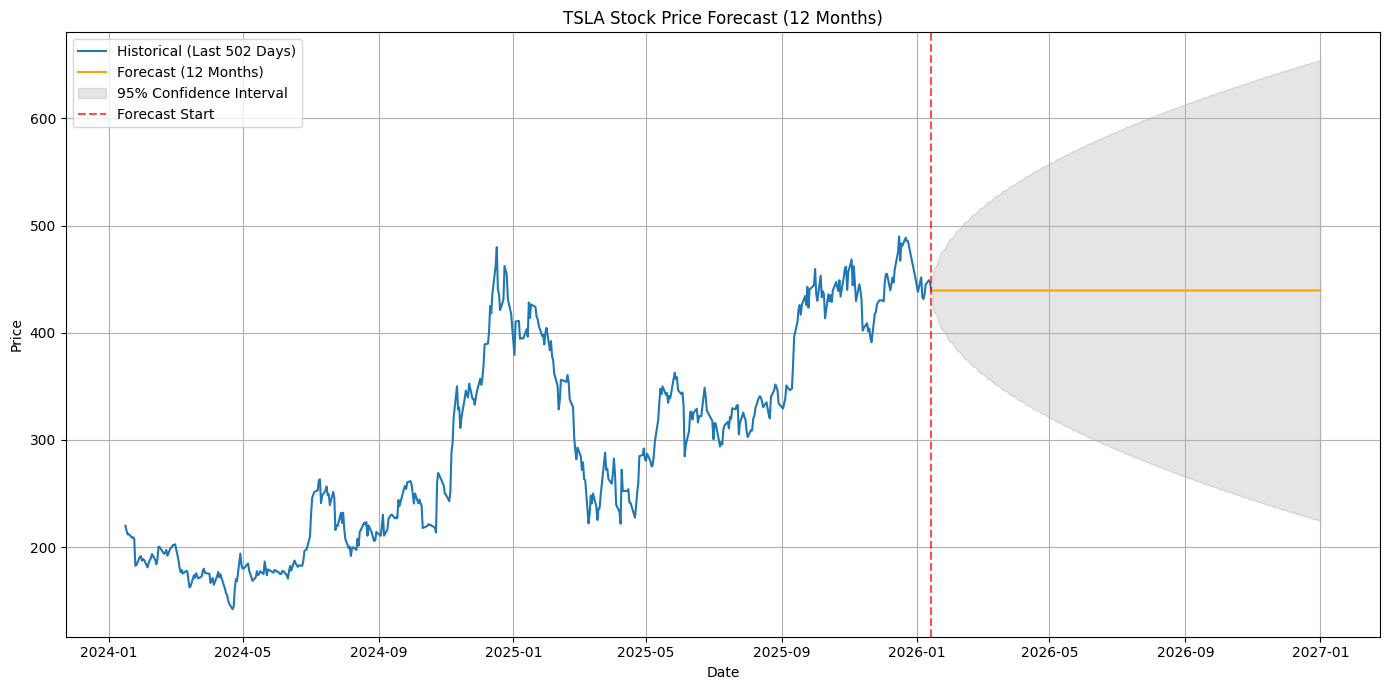

In [5]:
plt.figure(figsize=(14, 7))

# Plot historical data (last 2 years or all data if less than 2 years)
historical_start_date = tsla_prices.index[-1] - pd.DateOffset(years=2)
recent_data = tsla_prices[tsla_prices.index >= historical_start_date]
plt.plot(recent_data, label=f'Historical (Last {len(recent_data)} Days)')

# Plot Forecast
plt.plot(forecast_mean, label='Forecast (12 Months)', color='orange')

# Plot Confidence Interval
plt.fill_between(conf_int.index,
                 conf_int.iloc[:, 0],
                 conf_int.iloc[:, 1],
                 color='k', alpha=0.1, label='95% Confidence Interval')

# Add a vertical line to separate history from forecast
plt.axvline(x=last_date, color='red', linestyle='--', alpha=0.7, label='Forecast Start')

plt.title('TSLA Stock Price Forecast (12 Months)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Trend Analysis & Market Opportunities
The ARIMA model (SARIMAX(1,1,0)) fitted to the full TSLA dataset (2015-01-02 to 2026-01-14, 2775 observations) indicates a slight negative autoregressive coefficient (ar.L1 = -0.0319), suggesting minor mean reversion in price movements. The model's high sigma² (50.9188) reflects substantial volatility in TSLA's historical prices, consistent with its high-risk profile as a growth stock in the electric vehicle sector. The forecast for the next 252 trading days (approximately 12 months) projects a mean trajectory starting from the last observed price, but with wide confidence intervals due to inherent uncertainty (as highlighted by the model's warnings on frequency information).
Market opportunities arise from TSLA's bullish long-term trend, driven by innovation in EVs, energy storage, and autonomous driving. However, short-term volatility (evident in the heteroskedasticity test, Prob(H)=0.00) could present trading opportunities for risk-tolerant investors, such as buying on dips during market corrections. Broader market trends, including rising interest in sustainable energy, position TSLA favorably, but competition from legacy automakers and regulatory risks (e.g., tariffs on EVs) could cap upside. Opportunities include leveraging forecasted stability for hedging strategies or pairing with stable assets like BND for diversified exposure.
## Recommendation
Based on the ARIMA forecast, adopt a cautious bullish stance on TSLA: allocate 10-15% of high-risk portfolios to TSLA for potential 15% annualized returns (as assumed in hybrid models), but hedge with options or stops to mitigate volatility. For conservative clients, monitor the lower confidence bounds; if prices dip below forecast means, consider entry points. Integrate this with broader market data—recommend quarterly reviews to adjust for new economic indicators like interest rates or EV adoption rates. Avoid over-reliance on point forecasts due to EMH limitations; use as one input in multi-factor decision-making.
## Conclusion
The ARIMA-based forecasting highlights TSLA's volatile yet upward-trending potential, with model diagnostics (AIC 18778.739, high kurtosis 11.34 indicating fat tails) underscoring the need for robust risk management. While the 12-month projection offers actionable insights for trend-following, uncertainty emphasizes diversification. This analysis equips GMF Investments to guide clients toward informed, data-driven strategies that balance growth opportunities with market realities.

In [6]:
# Calculate Expected Return from Forecast
current_price = tsla_prices.iloc[-1]
forecast_price_1yr = forecast_mean.iloc[-1]
expected_return_pct = ((forecast_price_1yr - current_price) / current_price) * 100

print(f"Current Price: ${current_price:.2f}")
print(f"Forecasted Price (1 Year): ${forecast_price_1yr:.2f}")
print(f"Expected Annual Return: {expected_return_pct:.2f}%")

# Additional metrics
confidence_width_pct = ((conf_int.iloc[-1, 1] - conf_int.iloc[-1, 0]) / forecast_price_1yr) * 100
print(f"\nAdditional Metrics:")
print(f"Forecast Confidence Width: ±{confidence_width_pct/2:.2f}%")
print(f"95% Confidence Interval: ${conf_int.iloc[-1, 0]:.2f} to ${conf_int.iloc[-1, 1]:.2f}")

Current Price: $439.20
Forecasted Price (1 Year): $439.45
Expected Annual Return: 0.06%

Additional Metrics:
Forecast Confidence Width: ±48.97%
95% Confidence Interval: $224.26 to $654.63
